In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
"""
read_data_function() function reads data from yfinance and adjust it to pandas DataFrame format
"""
def read_data_function():
    ticker= "^GSPC"
    start_date = "2020-01-01"
    stop_date = "2025-01-01"
    data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
    data_frame = pd.DataFrame(data_frame)
    return data_frame

In [3]:
read_data_function()

/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000


In [4]:
"""
data_prep_function(sequence_dataset, window_size) function turns data (sequence_dataset parameter) into windows with the size given in window_size parameter
"""
def data_prep_function(sequence_dataset, window_size):
    for i in range(1, window_size + 1):
        sequence_dataset[f"Open-{i}"] = sequence_dataset["Open"].shift(i)

    sequence_dataset = sequence_dataset.drop(["Close", "High","Low", "Volume"], axis = 1)
    sequence_dataset.dropna(inplace = True)
    return sequence_dataset

In [5]:
"""
feature_target_modeling(dataset, window_size) function divide data into features and targets, create train and test sets and transform them into torch.tensor format, which enables model to correctly process data
"""
def feature_target_modeling(dataset, window_size):
    X = dataset[:, 1:]
    y = dataset[:,0]
    X = np.flip(X, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)
    X_train = np.reshape(X_train, (X_train.shape[0], window_size, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], window_size, 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))
    X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

In [6]:
"""
CustomLSTMDataSet, inheriting TensorDataSet object, helps with getting correct format of values from target and feature
"""
class CustomLSTMDataSet(TensorDataset):
    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)

        return X,y

In [7]:
"""
split_groups(X_train, X_test, y_train, y_test) function assigns given features and targets to train, test and validation sets and transform the following sets to DataLoader objects for further processing
"""
def split_groups(X_train, X_test, y_train, y_test):
    train_dataset = CustomLSTMDataSet(X_train, y_train)
    test_dataset = CustomLSTMDataSet(X_test, y_test)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_sub, val_sub = random_split(train_dataset, [train_size, val_size])
    val_loader = torch.utils.data.DataLoader(val_sub, batch_size=16, shuffle=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = False)
    return train_loader, val_loader, test_loader

In [8]:
"""
CustomLSTM(nn.Module) is customised LSTM model taken from https://github.com/piEsposito/pytorch-lstm-by-hand/blob/master/LSTM.ipynb and additionally finetuned for our use-case. It uses only two matrix multiplications, which makes it execute faster due to vector optimization
"""
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz = 1):
        super().__init__()
        self.input_sz= input_sz
        self.hidden_size= hidden_sz
        self.W= nn.Parameter(torch.Tensor(input_sz, hidden_sz* 4))
        self.U= nn.Parameter(torch.Tensor(hidden_sz, hidden_sz* 4))
        self.bias= nn.Parameter(torch.Tensor(hidden_sz* 4))
        self.linear = nn.Linear(hidden_sz, output_sz)
        self.init_weights()

    def init_weights(self):
        stdv= 1.0/ math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x,
                init_states=None):


        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _= x.size()
        hidden_seq= []
        if init_states is None:

            h_t, c_t= (torch.zeros(bs, self.hidden_size).to(x.device),
                            torch.zeros(bs, self.hidden_size).to(x.device))
        else:

             h_t, c_t= init_states

        HS= self.hidden_size
        for t in range(seq_sz):
                        x_t= x[:, t, :]
            # batch the computations into a single matrix multiplication
                        gates= x_t@ self.W+ h_t@ self.U+ self.bias
                        i_t, f_t, g_t, o_t= (
                            torch.sigmoid(gates[:, :HS]),# input
                            torch.sigmoid(gates[:, HS:HS*2]),# forget
                            torch.tanh(gates[:, HS*2:HS*3]),
                            torch.sigmoid(gates[:, HS*3:]),# output
                        )
                        c_t= f_t* c_t+ i_t* g_t
                        h_t= o_t* torch.tanh(c_t)
                        hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq= torch.cat(hidden_seq, dim=0)
            # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq= hidden_seq.transpose(0, 1).contiguous()
        output = self.linear(hidden_seq[:, -1, :])
        return output

In [9]:
"""
train_model(model: torch.nn.Module, train_dataloader : DataLoader, val_dataloader: DataLoader, epochs: int) trains the model and return validation loss and train loss for evaluation
"""
def train_model(model: torch.nn.Module, train_dataloader : DataLoader, val_dataloader: DataLoader, epochs: int):
    model.train(True)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_function = torch.nn.MSELoss()
    loss_vectorize_train = np.zeros(epochs)
    loss_vectorize_val = np.zeros(epochs)

    for epoch in range(epochs):
        epoch_loss_train = 0
        for batch_idx_train, act_batch_train in enumerate(train_dataloader):
            X_trained, y_trained = act_batch_train[0], act_batch_train[1]
            optimizer.zero_grad()
            preds = model(X_trained)
            loss = loss_function(preds, y_trained)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            loss_vectorize_train[epoch] = epoch_loss_train / len(train_dataloader)

        model.eval()

        with torch.no_grad():
            epoch_loss_val = 0
            for batch_idx_val, act_batch_val in enumerate(val_dataloader):
                X_validated, y_validated = act_batch_val[0], act_batch_val[1]
                preds_2 = model(X_validated)
                loss = loss_function(preds_2, y_validated)
                epoch_loss_val += loss.item()
                loss_vectorize_val[epoch] = epoch_loss_val / len(val_dataloader)

        print(f"Epoch {epoch}: Train loss {loss_vectorize_train[epoch] : .6f} || Val loss {loss_vectorize_val[epoch] : .6f}")



    return loss_vectorize_train, loss_vectorize_val, model

In [10]:
"""
Using previously mentioned functions to process data, define model and split sets. In addition, we scale our data using MinMaxScaler() (For Window Size 10).
"""
data = read_data_function()
window_data_10 = data_prep_function(data, 10)
window_data_10 = window_data_10.to_numpy()
scaler = MinMaxScaler()
normalized_data_10 = scaler.fit_transform(window_data_10)
X_train_10, X_test_10, y_train_10, y_test_10 = feature_target_modeling(normalized_data_10,10)
train_loader_10, val_loader_10, test_loader_10 = split_groups(X_train_10, X_test_10, y_train_10, y_test_10)
model_10 = CustomLSTM(1, 8)


/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [11]:
"""
Training and assesing model's loss (For Window Size 10)
"""
loss_train_10, loss_val_10, model_10 = train_model(model_10, train_loader_10, val_loader_10,4)

Epoch 0: Train loss  0.441889 || Val loss  0.310257
Epoch 1: Train loss  0.123162 || Val loss  0.008369
Epoch 2: Train loss  0.005532 || Val loss  0.003077
Epoch 3: Train loss  0.002184 || Val loss  0.001052


In [12]:
"""
Evaluating model on test set + Adjusting Tensor Size for matplotlib.pyplot visualizations (For Window Size 10)
"""
test_predictions_10 = model_10(X_test_10).detach().numpy().flatten()

final_var_10 = np.zeros((X_test_10.shape[0], 11))
final_var_10[:, 0] = test_predictions_10
final_var_10 = scaler.inverse_transform(final_var_10)

test_predictions_10 = final_var_10[:, 0]
test_predictions_10

array([4156.22188363, 4774.08772618, 4754.72530606, 4410.32670641,
       4904.47729338, 2717.37419707, 3235.87392048, 3206.36560942,
       5541.88610806, 4504.97671085, 3842.62738115, 3238.30520327,
       4041.4179734 , 5206.26584522, 4061.55376739, 4236.48851506,
       3584.31631915, 4485.25748827, 4484.75081065, 4244.2575718 ,
       4048.35977366, 5635.63210727, 3995.95531704, 5397.81149095,
       4108.80088887, 4601.57101706, 3998.14050575, 4214.82272673,
       4215.64273849, 4183.29359155, 4173.58566659, 4176.63365618,
       4043.1865907 , 3447.21361317, 4597.1050999 , 4208.30768576,
       4245.37031553, 4046.5877604 , 4215.19650901, 5537.33642382,
       5557.65990135, 4009.50498125, 3543.8417658 , 4574.03134549,
       4462.85998321, 5214.1768532 , 4008.56180925, 4337.6866145 ,
       4599.45171002, 5071.44590528, 3728.77049167, 5316.1499113 ,
       4250.64084942, 3238.1580449 , 3842.80668797, 3830.46847681,
       4430.14690228, 3818.17486595, 5039.39254668, 4487.46395

In [13]:
final_var_10_2 = np.zeros((X_test_10.shape[0],11))
final_var_10_2[:, 0] = y_test_10.flatten()

final_var_10_2 = scaler.inverse_transform(final_var_10_2)

new_y_test_10 = final_var_10_2[:, 0]
new_y_test_10

array([4001.83010587, 4745.20008388, 4669.14003128, 4386.74989676,
       4973.04970134, 2344.4399431 , 3138.69992347, 3143.639917  ,
       5976.75971578, 4538.76993427, 3774.70994117, 3213.32008795,
       3919.41994288, 5259.76991452, 4102.20015644, 4191.97989778,
       3371.87984375, 4462.12011617, 4532.24017746, 4206.81980137,
       4112.37989381, 5920.6699606 , 3879.34011358, 5644.08986522,
       3763.52001815, 4613.3398385 , 3959.20998338, 4188.24999891,
       4226.70995407, 4075.28998314, 4077.38993319, 4143.74024965,
       4053.71996096, 3369.04002666, 4568.83982433, 4169.9199514 ,
       4290.4598688 , 4055.1498876 , 4156.16019031, 5859.430115  ,
       6008.85993866, 3911.84004125, 3403.14986699, 4498.02970345,
       4519.56984116, 5352.99995382, 3876.73993824, 4259.31006264,
       4578.83006699, 5173.49027859, 3703.11014579, 5473.58990506,
       4150.33985008, 3130.99997456, 3881.8500695 , 3808.26001367,
       4348.83986113, 3803.13992092, 5110.52007687, 4530.60015

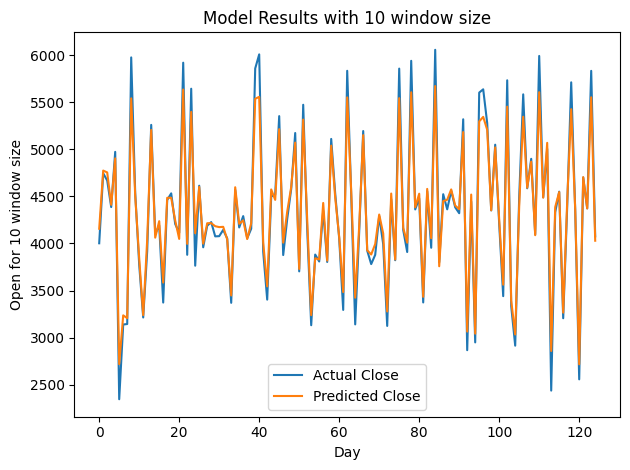

In [14]:
plt.plot(new_y_test_10, label='Actual Close')
plt.plot(test_predictions_10, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 10 window size')
plt.legend()
plt.title("Model Results with 10 window size")
plt.tight_layout()
plt.show()

In [15]:
"""
Using previously mentioned functions to process data, define model and split sets. In addition, we scale our data using MinMaxScaler() (For Window Size 20).
"""
data_20 = read_data_function()
window_data_20 = data_prep_function(data_20, 20)
window_data_20 = window_data_20.to_numpy()
scaler_20 = MinMaxScaler()
normalized_data_20 = scaler_20.fit_transform(window_data_20)
X_train_20, X_test_20, y_train_20, y_test_20 = feature_target_modeling(normalized_data_20,20)
train_loader_20, val_loader_20, test_loader_20 = split_groups(X_train_20, X_test_20, y_train_20, y_test_20)
model_20 = CustomLSTM(1, 8)

/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [16]:
"""
Training and assesing model's loss (For Window Size 20)
"""
loss_train_20, loss_val_20, model_20 = train_model(model_20, train_loader_20, val_loader_20,4)

Epoch 0: Train loss  0.457829 || Val loss  0.193877
Epoch 1: Train loss  0.057029 || Val loss  0.022756
Epoch 2: Train loss  0.019927 || Val loss  0.017236
Epoch 3: Train loss  0.013918 || Val loss  0.010968


In [17]:
"""
Evaluating model on test set + Adjusting Tensor Size for matplotlib.pyplot visualizations (For Window Size 20)
"""
test_predictions_20 = model_20(X_test_20).detach().numpy().flatten()

final_var_20 = np.zeros((X_test_20.shape[0], 21))
final_var_20[:, 0] = test_predictions_20
final_var_20 = scaler_20.inverse_transform(final_var_20)

test_predictions_20 = final_var_20[:, 0]
test_predictions_20

array([3583.66429434, 3748.81878303, 3523.55620985, 3980.1232264 ,
       3662.82259678, 4371.16650377, 3652.57539296, 4454.26819794,
       3456.77664373, 4388.66340846, 4536.06674807, 4493.09604904,
       4029.92863967, 5010.5298081 , 4532.13263865, 4421.71767042,
       4517.94317509, 4418.06836906, 3703.84989964, 4454.83939884,
       4404.16167598, 3821.61961717, 3823.19828697, 4872.0322671 ,
       4880.77143715, 4236.78826535, 4739.04954289, 4291.74490103,
       4365.81627796, 4450.78688352, 4734.50959375, 4080.72205165,
       4386.29846013, 4534.03822644, 4299.00931774, 4826.48901324,
       3627.37237003, 5019.76614707, 3813.49081479, 4129.66172087,
       4750.59921155, 4436.33321408, 4012.75163465, 3785.14109296,
       4311.16029817, 4396.95317946, 3796.92191347, 4438.21050218,
       4444.81044221, 4425.04050659, 4491.21445939, 4195.1438029 ,
       4116.94927463, 3485.59546119, 4410.03646481, 4564.8706233 ,
       5046.92343325, 4300.33170556, 4019.90896534, 4265.83415

In [18]:
final_var_20_2 = np.zeros((X_test_20.shape[0],21))
final_var_20_2[:, 0] = y_test_20.flatten()

final_var_20_2 = scaler_20.inverse_transform(final_var_20_2)

new_y_test_20 = final_var_20_2[:, 0]
new_y_test_20

array([3098.89992148, 3289.9198722 , 2948.05007607, 3653.78005408,
       3138.69992347, 4329.37986369, 2863.88991697, 4434.54988094,
       2425.65990965, 4380.00981667, 4471.37977407, 4494.2699201 ,
       3693.41987983, 5874.16995088, 4670.25979333, 4435.79008647,
       4690.85992861, 4404.53998621, 3224.2900658 , 4455.7499696 ,
       4447.68999206, 3434.27997656, 3360.47993704, 5584.24032669,
       5603.33989931, 3909.42992662, 5139.08985707, 4176.79983195,
       4279.49996563, 4451.29990026, 5175.1400372 , 3901.79002966,
       4458.97024769, 4710.29977667, 4190.74014505, 5293.12981311,
       2813.47996576, 6003.97994047, 3238.93996528, 3916.39991338,
       5242.47993715, 4602.85989805, 3659.12982709, 3062.54002956,
       4206.04982346, 4322.56009168, 3372.94991156, 4440.93995049,
       4521.77970719, 4155.76999421, 4578.83006699, 3984.60012384,
       3935.32006597, 2868.87988775, 4442.04001596, 4733.56008262,
       6068.16997195, 4198.1001015 , 3657.10006027, 4052.35014

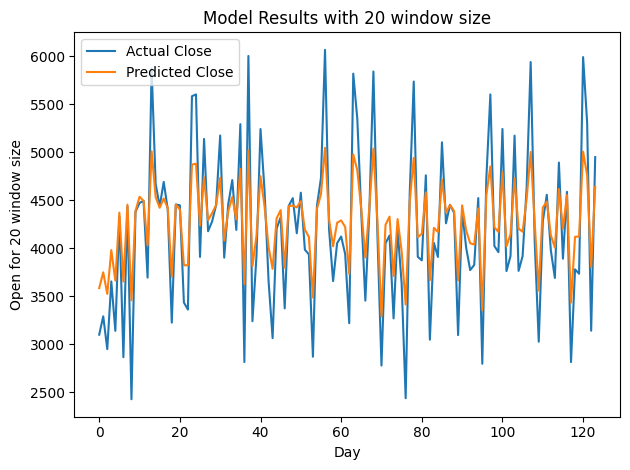

In [19]:
plt.plot(new_y_test_20, label='Actual Close')
plt.plot(test_predictions_20, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 20 window size')
plt.legend()
plt.title("Model Results with 20 window size")
plt.tight_layout()
plt.show()

In [20]:
"""
Using previously mentioned functions to process data, define model and split sets. In addition, we scale our data using MinMaxScaler() (For Window Size 50).
"""
data_50 = read_data_function()
window_data_50 = data_prep_function(data_50, 50)
window_data_50 = window_data_50.to_numpy()
scaler_50 = MinMaxScaler()
normalized_data_50 = scaler_50.fit_transform(window_data_50)
X_train_50, X_test_50, y_train_50, y_test_50 = feature_target_modeling(normalized_data_50,50)
train_loader_50, val_loader_50, test_loader_50 = split_groups(X_train_50, X_test_50, y_train_50, y_test_50)
model_50 = CustomLSTM(1, 8)

/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/3369913485.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_frame = yf.download(ticker, start = start_date, end = stop_date, interval = "1d")
[*********************100%***********************]  1 of 1 completed


In [21]:
"""
Training and assesing model's loss (For Window Size 50)
"""
loss_train_50, loss_val_50, model_50 = train_model(model_50, train_loader_50, val_loader_50,4)

Epoch 0: Train loss  0.029537 || Val loss  0.023206
Epoch 1: Train loss  0.015930 || Val loss  0.006695
Epoch 2: Train loss  0.002339 || Val loss  0.001316
Epoch 3: Train loss  0.001262 || Val loss  0.000996


In [22]:
"""
Evaluating model on test set + Adjusting Tensor Size for matplotlib.pyplot visualizations (For Window Size 50)
"""
test_predictions_50 = model_50(X_test_50).detach().numpy().flatten()

final_var_50 = np.zeros((X_test_50.shape[0], 51))
final_var_50[:, 0] = test_predictions_50
final_var_50 = scaler_50.inverse_transform(final_var_50)

test_predictions_50 = final_var_50[:, 0]
test_predictions_50

array([3699.89405605, 4061.57697313, 3630.74999439, 3153.99607462,
       3441.42519499, 5267.52697219, 3921.7487808 , 3998.70865029,
       5623.13315388, 4385.75533252, 3653.30190255, 5600.83571652,
       5358.6338557 , 4178.93736398, 5857.77152688, 4726.44825783,
       4138.86840176, 5535.56033541, 4418.28729544, 4740.22975308,
       4292.1286448 , 4524.1648049 , 5516.4501221 , 3958.60346446,
       3822.57931619, 4095.59953722, 4001.89032761, 4536.3544993 ,
       3774.06867024, 4343.63860488, 3947.49481814, 3806.48415165,
       3966.51741561, 4494.94865982, 3684.00117768, 5255.23743649,
       2972.14307203, 3269.50900524, 5343.99272912, 5802.02249994,
       4437.67122333, 4573.6405834 , 4721.71451242, 5332.70771915,
       4429.56279672, 4150.70672724, 4579.20724523, 4345.39024236,
       4756.00671593, 4433.35880367, 4111.07822136, 5254.52224678,
       3568.2119855 , 5618.09943177, 3985.27320362, 3908.32669159,
       4047.88547089, 5210.93982169, 4199.04689587, 4379.05985

In [23]:
final_var_50_2 = np.zeros((X_test_50.shape[0],51))
final_var_50_2[:, 0] = y_test_50.flatten()

final_var_50_2 = scaler_50.inverse_transform(final_var_50_2)

new_y_test_50 = final_var_50_2[:, 0]
new_y_test_50

array([3825.96995841, 4179.79982527, 3694.72992899, 2939.50000454,
       3435.94999775, 5139.08985707, 4036.08008625, 4136.68989178,
       5608.55994655, 4493.1001242 , 3656.08002632, 5433.66991239,
       5298.68990941, 4126.54977398, 6024.97015864, 4631.97031549,
       4198.1001015 , 5461.83987461, 4408.85987698, 4691.00006866,
       4351.00965481, 4550.16021908, 5460.70992466, 4020.85009977,
       3880.93995154, 4166.79000591, 4048.26004556, 4449.1201451 ,
       3840.27001714, 4354.16993756, 4040.16995716, 3817.99997388,
       4102.20015644, 4546.12015563, 3520.37011778, 5187.20023223,
       2558.97999444, 3213.32008795, 5217.02968815, 6003.60004546,
       4401.30997302, 4456.06013418, 4679.41983634, 5257.97028076,
       4511.70026392, 4129.58010457, 4455.7499696 , 4369.02002904,
       4703.95996737, 4447.68999206, 4082.5500983 , 5103.77977038,
       3579.31010434, 5612.74015006, 3764.0500147 , 3992.77997885,
       4140.10985247, 5132.37988785, 4232.99022083, 4450.47988

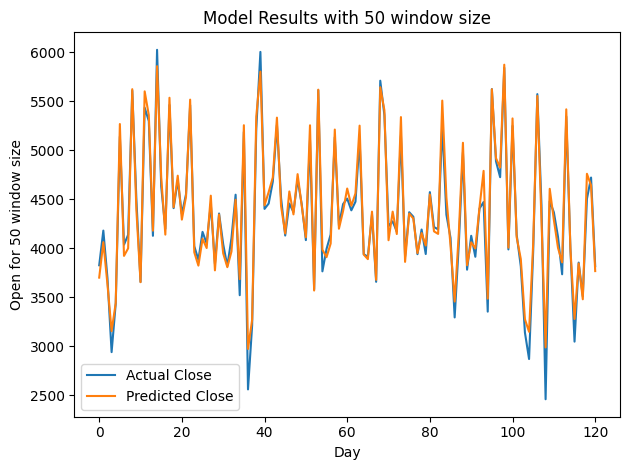

In [24]:
plt.plot(new_y_test_50, label='Actual Close')
plt.plot(test_predictions_50, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Open for 50 window size')
plt.title("Model Results with 50 window size")
plt.tight_layout()
plt.legend()
plt.show()

/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/1727868917.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend()
/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/1727868917.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,2].legend()
/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/1727868917.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,1].legend()
/var/folders/w9/306tg7496r9fjs6p9gqt6p5w0000gn/T/ipykernel_8104/1727868917.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start wi

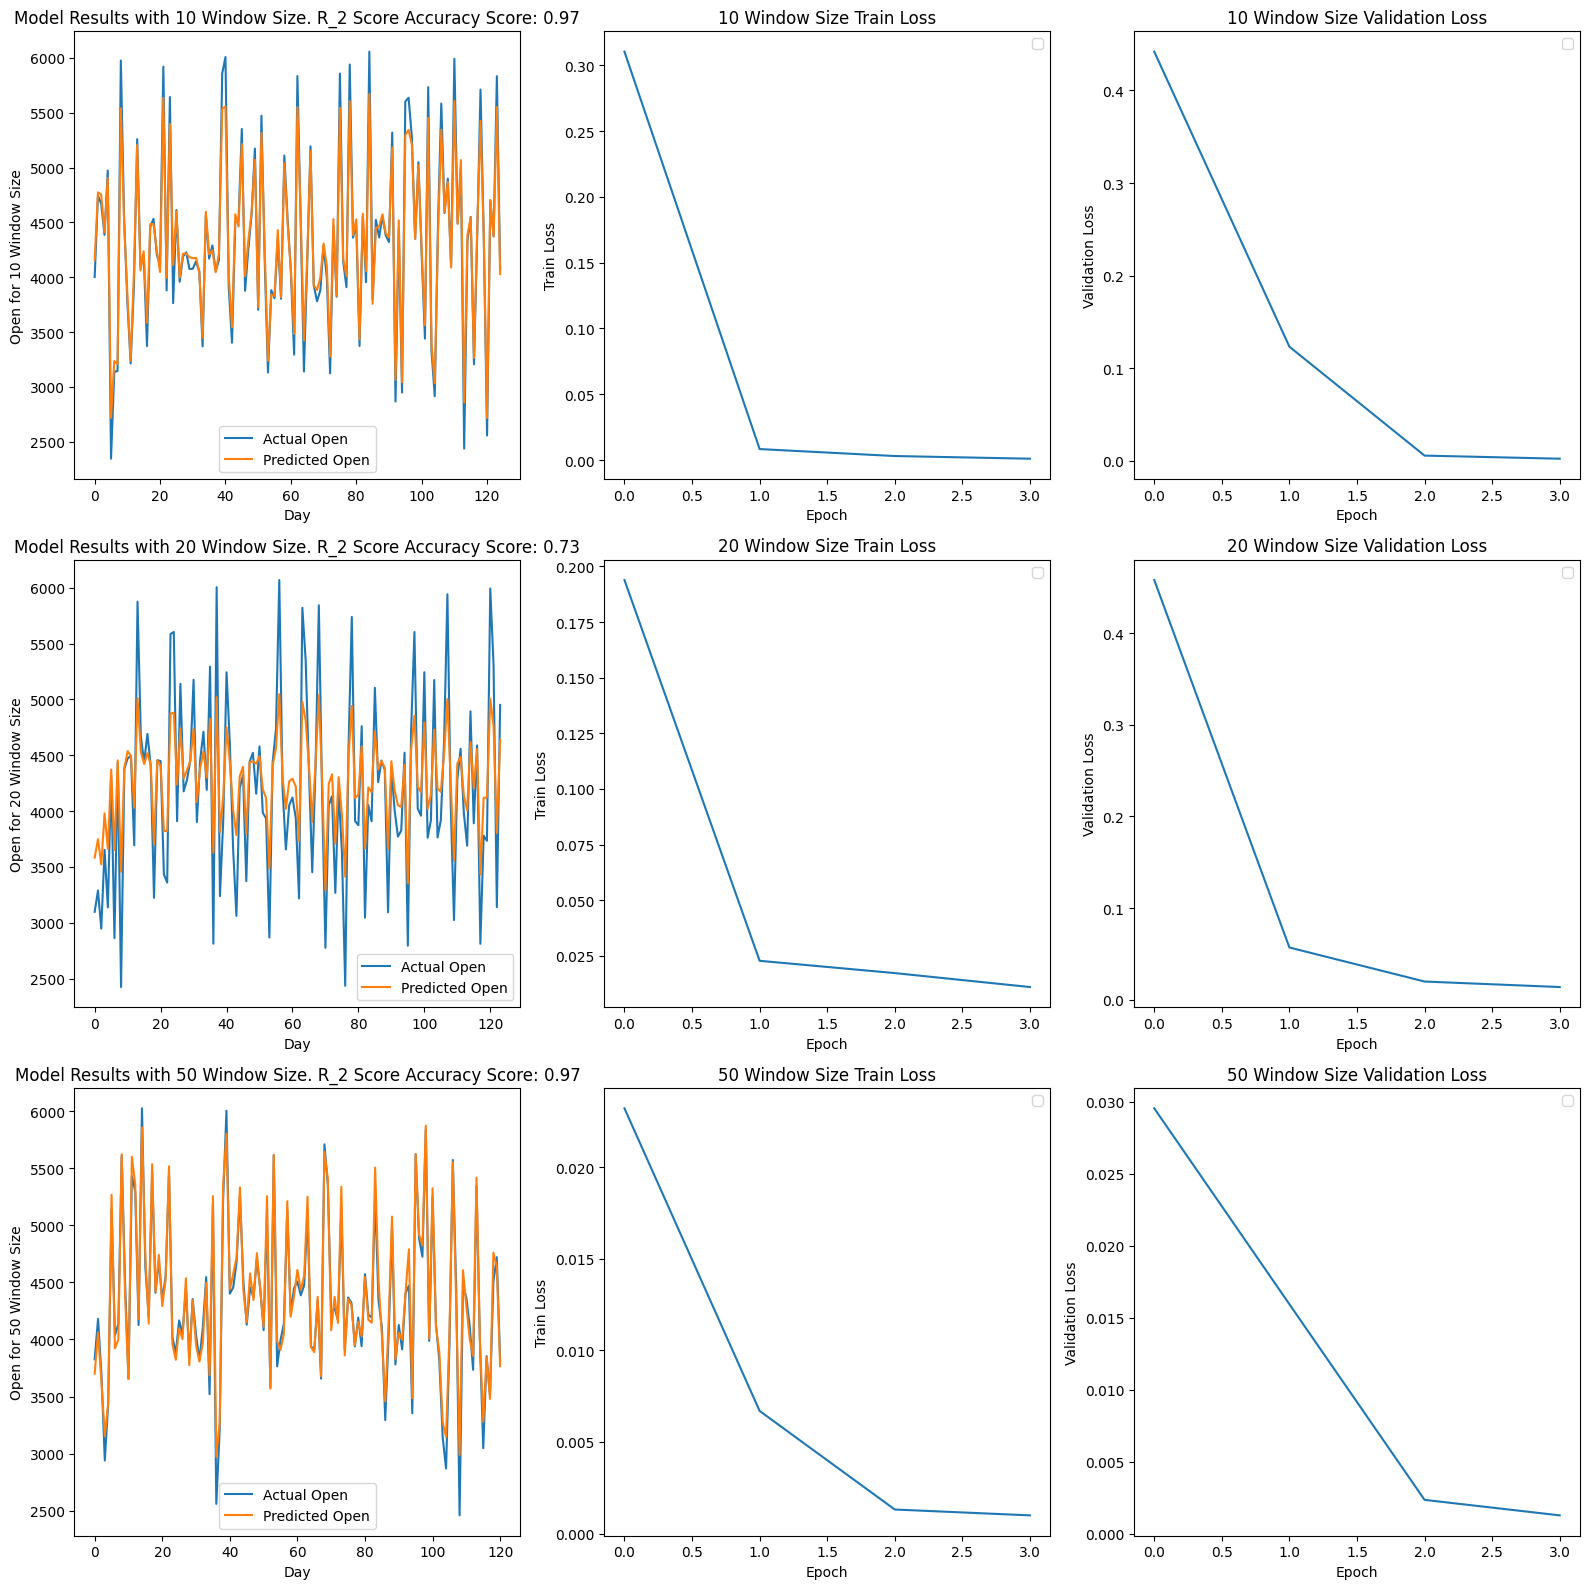

<Figure size 640x480 with 0 Axes>

In [25]:
"""
Extended visualization gird with validation adn train loss for every window size, assesing accuracy using R squared scored and visualization of results using test sets
"""
predictions_10, actual_10, loss_vec_10_val, loss_vec_10_train = test_predictions_10, new_y_test_10, loss_train_10, loss_val_10
predictions_20, actual_20, loss_vec_20_val, loss_vec_20_train = test_predictions_20, new_y_test_20, loss_train_20, loss_val_20
predictions_50, actual_50, loss_vec_50_val, loss_vec_50_train = test_predictions_50, new_y_test_50, loss_train_50, loss_val_50

accuracy_10 = r2_score(actual_10, predictions_10)
accuracy_20 = r2_score(actual_20, predictions_20)
accuracy_50 = r2_score(actual_50, predictions_50)

fig, axes = plt.subplots(3,3, figsize = (16,16))

axes[0,0].plot(actual_10, label='Actual Open')
axes[0,0].plot(predictions_10, label='Predicted Open')
axes[0,0].set_title(f"Model Results with 10 Window Size. R_2 Score Accuracy Score: {accuracy_10:.2f}")
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Open for 10 Window Size')
axes[0,0].legend()


axes[0,1].plot(loss_vec_10_train)
axes[0,1].set_title("10 Window Size Train Loss")
axes[0,1].set_xlabel("Epoch")
axes[0,1].set_ylabel("Train Loss")
axes[0,1].legend()


axes[0,2].plot(loss_vec_10_val)
axes[0,2].set_title("10 Window Size Validation Loss")
axes[0,2].set_xlabel("Epoch")
axes[0,2].set_ylabel("Validation Loss")
axes[0,2].legend()


axes[1,0].plot(actual_20, label='Actual Open')
axes[1,0].plot(predictions_20, label='Predicted Open')
axes[1,0].set_title(f"Model Results with 20 Window Size. R_2 Score Accuracy Score: {accuracy_20:.2f}")
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Open for 20 Window Size')
axes[1,0].legend()


axes[1,1].plot(loss_vec_20_train)
axes[1,1].set_title("20 Window Size Train Loss")
axes[1,1].set_xlabel("Epoch")
axes[1,1].set_ylabel("Train Loss")
axes[1,1].legend()


axes[1,2].plot(loss_vec_20_val)
axes[1,2].set_title("20 Window Size Validation Loss")
axes[1,2].set_xlabel("Epoch")
axes[1,2].set_ylabel("Validation Loss")
axes[1,2].legend()

axes[2,0].plot(actual_50, label='Actual Open')
axes[2,0].plot(predictions_50, label='Predicted Open')
axes[2,0].set_title(f"Model Results with 50 Window Size. R_2 Score Accuracy Score: {accuracy_50:.2f}")
axes[2,0].set_xlabel('Day')
axes[2,0].set_ylabel('Open for 50 Window Size')
axes[2,0].legend()


axes[2,1].plot(loss_vec_50_train)
axes[2,1].set_title("50 Window Size Train Loss")
axes[2,1].set_xlabel("Epoch")
axes[2,1].set_ylabel("Train Loss")
axes[2,1].legend()


axes[2,2].plot(loss_vec_50_val)
axes[2,2].set_title("50 Window Size Validation Loss")
axes[2,2].set_xlabel("Epoch")
axes[2,2].set_ylabel("Validation Loss")
axes[2,2].legend()

plt.tight_layout()
plt.show()
plt.savefig("results.png")






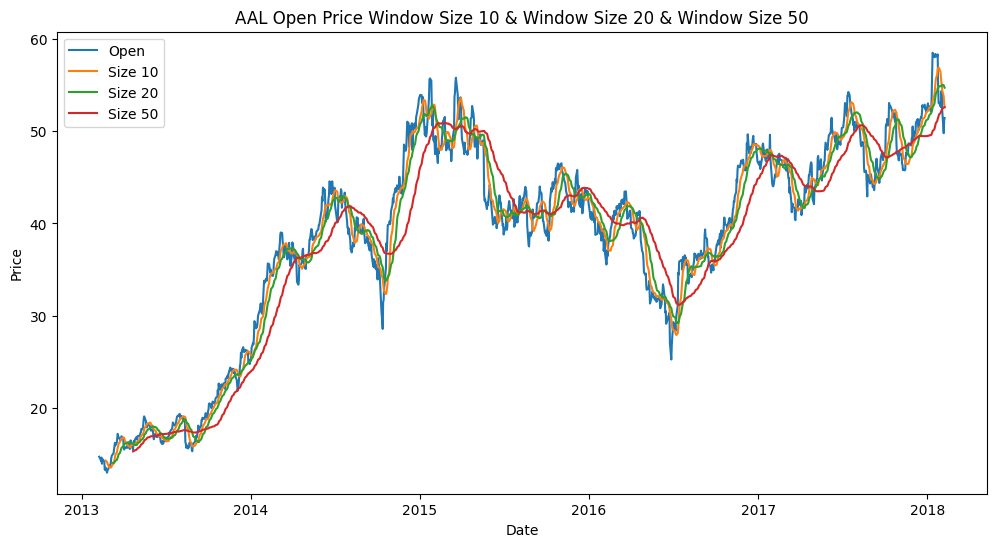

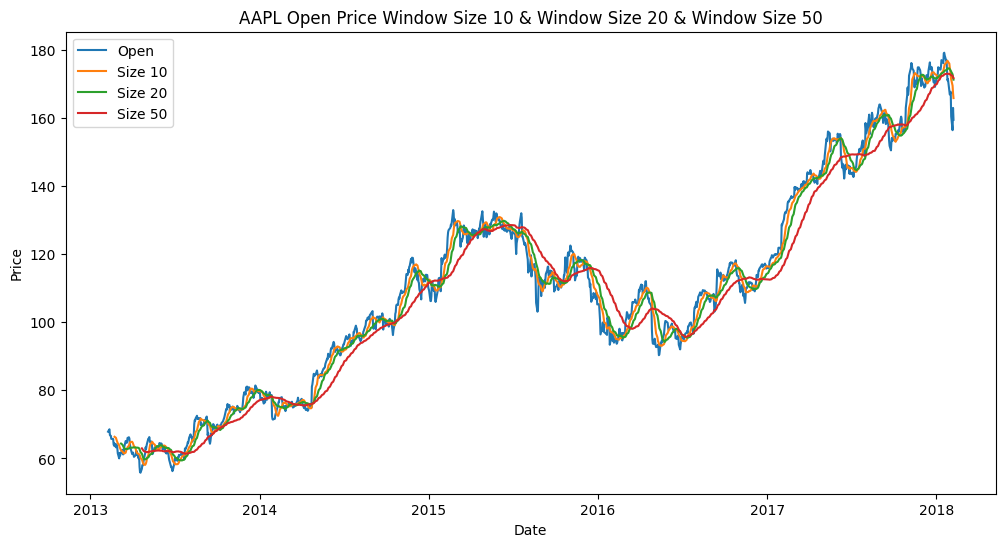

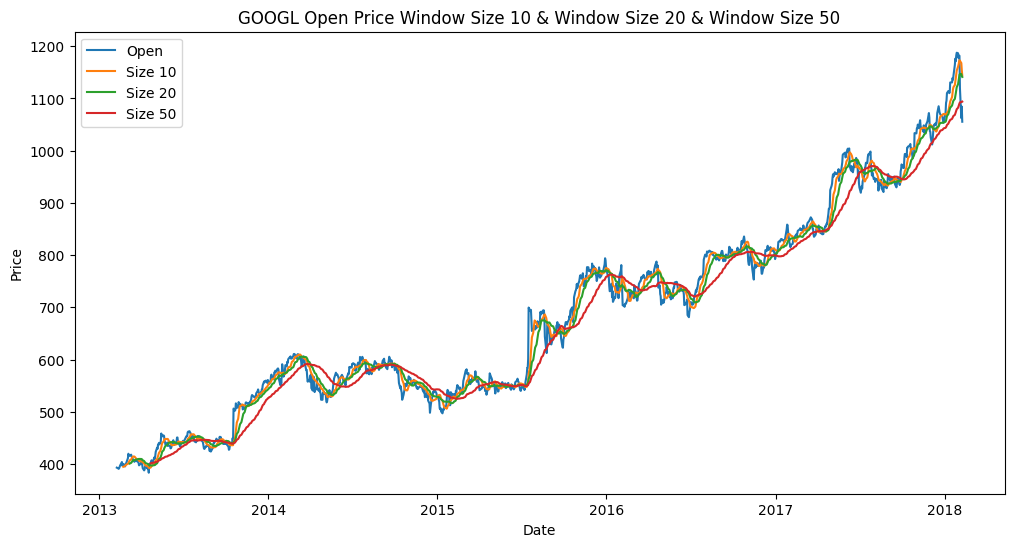

In [30]:
"""
Using all_stocks_5yr.csv dataset to visualize stock data for a given window size
"""
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('all_stocks_5yr.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Name', 'date'])
df['MA10'] = df.groupby('Name')['open'].transform(lambda x: x.rolling(window=10).mean())
df['MA20'] = df.groupby('Name')['open'].transform(lambda x: x.rolling(window=20).mean())
df['MA50'] = df.groupby('Name')['open'].transform(lambda x: x.rolling(window=50).mean())

tickers = ['AAL', 'AAPL', 'GOOGL']

for ticker in tickers:

  sub = df[df['Name'] == ticker]
  plt.figure(figsize=(12,6))
  plt.plot(sub['date'], sub['close'], label='Open')
  plt.plot(sub['date'], sub['MA10'], label='Size 10')
  plt.plot(sub['date'], sub['MA20'], label='Size 20')
  plt.plot(sub['date'], sub['MA50'], label='Size 50')
  plt.title(f'{ticker} Open Price Window Size 10 & Window Size 20 & Window Size 50')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()